# 1. Problem Statement

# Clustering Solar Energy Production Zones

Objective:
Group geographical areas (cities) based on solar energy production using unsupervised machine learning
and visualize the clusters on an interactive map.


# 2. Imports & Configuration

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import folium
from geopy.geocoders import Nominatim
import time

pd.set_option('display.max_columns', None)


# 3. Data Loading 

In [7]:
df_raw = pd.read_csv(r"C:\Users\Admin\OneDrive\Desktop\OneDrive_1_1-21-2026\Statewide Solar Projects.csv", low_memory=False)
df = df_raw.copy()


# 4. Data Overview

In [9]:
df_raw.shape
df_raw.info()
df_raw.head()
df_raw.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218115 entries, 0 to 218114
Data columns (total 17 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Data Through Date                            218115 non-null  object 
 1   Project ID                                   218112 non-null  object 
 2   Interconnection Date                         218115 non-null  object 
 3   Utility                                      218115 non-null  object 
 4   City/Town                                    218057 non-null  object 
 5   County                                       218115 non-null  object 
 6   Zip                                          218019 non-null  float64
 7   Division                                     132881 non-null  object 
 8   Substation                                   138171 non-null  object 
 9   Circuit ID                                   218085 non-nul

Data Through Date                                   0
Project ID                                          3
Interconnection Date                                0
Utility                                             0
City/Town                                          58
County                                              0
Zip                                                96
Division                                        85234
Substation                                      79944
Circuit ID                                         30
Developer                                       10550
Metering Method                                   463
Estimated PV System Size (kWdc)                     0
PV System Size (kWac)                               0
Estimated Annual PV Energy Production (kWh)         0
Energy Storage System Size (kWac)              214024
Number of Projects                                  0
dtype: int64

# 5. Data Cleaning 

In [11]:
df['City/Town'] = df['City/Town'].fillna('Unknown')
df['Zip'] = df['Zip'].fillna('Unknown')
df['Circuit ID'] = df['Circuit ID'].fillna('Not Available')

df['Data Through Date'] = pd.to_datetime(df['Data Through Date'])
df['Interconnection Date'] = pd.to_datetime(df['Interconnection Date'])


# 6. Project-Level Feature Engineering 

In [13]:
df['interconnection_year'] = df['Interconnection Date'].dt.year
df['project_age_years'] = pd.Timestamp.today().year - df['interconnection_year']

df['dc_ac_ratio'] = (
    df['Estimated PV System Size (kWdc)'] /
    df['PV System Size (kWac)']
)

df['energy_per_kw'] = (
    df['Estimated Annual PV Energy Production (kWh)'] /
    df['Estimated PV System Size (kWdc)']
)

df['has_energy_storage'] = (
    df['Energy Storage System Size (kWac)'] > 0
).astype(int)


# 7. Geographical Aggregation (CITY LEVEL – CRITICAL)

In [15]:
area_df = df.groupby('City/Town').agg({
    'Estimated Annual PV Energy Production (kWh)': 'sum',
    'Estimated PV System Size (kWdc)': 'sum',
    'PV System Size (kWac)': 'sum',
    'Number of Projects': 'sum',
    'has_energy_storage': 'sum'
}).reset_index()


# 8.  Area-Level Feature Engineering

In [17]:
area_df['energy_per_kw'] = (
    area_df['Estimated Annual PV Energy Production (kWh)'] /
    area_df['Estimated PV System Size (kWdc)']
)

area_df['projects_per_mw'] = (
    area_df['Number of Projects'] /
    (area_df['Estimated PV System Size (kWdc)'] / 1000)
)

area_df['storage_penetration'] = (
    area_df['has_energy_storage'] /
    area_df['Number of Projects']
)

area_df = area_df.fillna(0)


# 9. Feature Selection for Clustering

In [19]:
cluster_features = [
    'Estimated Annual PV Energy Production (kWh)',
    'energy_per_kw',
    'projects_per_mw',
    'storage_penetration'
]

X = area_df[cluster_features]


# 10. Feature Scaling

In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# 10. Optimal K Check (Elbow Method)

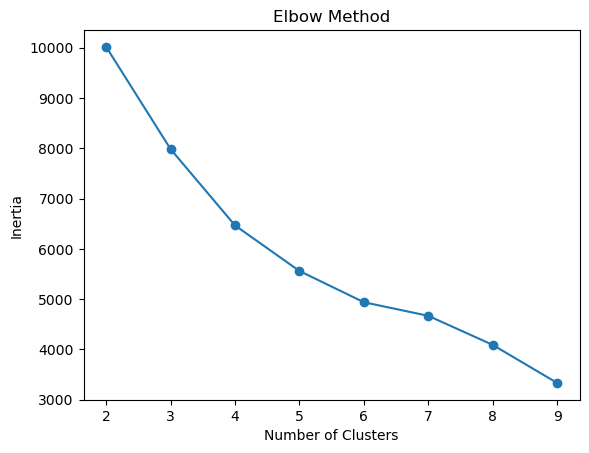

In [23]:
inertia = []
K = range(2, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


# 12. Clustering Model

In [25]:
kmeans = KMeans(n_clusters=3, random_state=42)
area_df['cluster'] = kmeans.fit_predict(X_scaled)


# 13. Cluster Validation

In [27]:
silhouette_score(X_scaled, area_df['cluster'])


np.float64(0.518565755066859)

# 14. Cluster Interpretation

In [29]:
area_df.groupby('cluster')[cluster_features].mean()


,Estimated Annual PV Energy Production (kWh),energy_per_kw,projects_per_mw,storage_penetration
cluster,,,,
0,7.462432e+05,1173.823169,106.258888,0.024003
1,1.885440e+05,1173.876495,89.262582,0.712267
2,1.731243e+07,1173.837451,14.839897,0.015899


# 15. Geocoding

In [31]:
geolocator = Nominatim(user_agent="solar_clustering")

def get_lat_lon(city):
    try:
        location = geolocator.geocode(city)
        if location:
            return location.latitude, location.longitude
    except:
        pass
    return None, None


In [33]:
area_df['lat'] = None
area_df['lon'] = None

for i, city in enumerate(area_df['City/Town']):
    lat, lon = get_lat_lon(city)
    area_df.loc[i, 'lat'] = lat
    area_df.loc[i, 'lon'] = lon
    time.sleep(1)


In [35]:
area_df = area_df.dropna(subset=['lat', 'lon'])


# 16. Folium Interactive Map

In [37]:
m = folium.Map(
    location=[area_df['lat'].mean(), area_df['lon'].mean()],
    zoom_start=6,
    tiles='cartodbpositron'
)

colors = {0: 'green', 1: 'orange', 2: 'red'}

for _, row in area_df.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=6,
        color=colors[row['cluster']],
        fill=True,
        fill_opacity=0.7,
        popup=f"""
        <b>City:</b> {row['City/Town']}<br>
        <b>Cluster:</b> {row['cluster']}<br>
        <b>Total Energy:</b> {round(row['Estimated Annual PV Energy Production (kWh)'],2)}
        """
    ).add_to(m)

m.save("solar_energy_clusters_map.html")


In [41]:
from IPython.display import IFrame

IFrame(
    src="solar_energy_clusters_map.html",
    width=900,
    height=600
)

In [39]:
area_df.to_csv("final_area_clusters.csv", index=False)


# Shape

In [40]:
df.shape         
area_df.shape    
area_df.head()


,City/Town,Estimated Annual PV Energy Production (kWh),Estimated PV System Size (kWdc),PV System Size (kWac),Number of Projects,has_energy_storage,energy_per_kw,projects_per_mw,storage_penetration,cluster,lat,lon
0,ADAMS,6897320,5875.87,4288.28,16,0,1173.838087,2.723001,0.000000,2,39.978779,-91.211006
1,ADAMS CENTER,219906,187.35,160.12,15,0,1173.771017,80.064051,0.000000,0,43.862684,-75.998157
2,ADDISON,32412,27.61,23.60,3,0,1173.922492,108.656284,0.000000,0,41.931696,-87.988956
3,ADIRONDACK,39279,33.46,28.60,4,1,1173.909145,119.545726,0.250000,0,43.763954,-73.758462
4,AFTON,138714,118.16,101.00,11,1,1173.950575,93.094110,0.090909,0,41.028899,-94.197046
